# Final Project - Training Data

This Notebook loads and displays some examples from the training dataset.

The training dataset contains a total of 3717 samples. All groups have been given the same training dataset and the final report will be graded based on the performance on this training data.

* You should expect the test dataset to have the same format as the training data: $270,000\times M$ numpy array, where $M$ is the number of test samples.
* This means that *any* pre-processing applied in the training data should also be applied in the test data.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

print(data_train.shape, labels_train.shape)

(270000, 3717) (3717,)


In [10]:
corrected_labels_train = labels_train.copy()

changes = {
    0: [2400, 361, 2439, 1865, 2671, 893, 3625],
    1: [1288, 3033, 3037, 3599, 780, 3140, 3372],
    2: [1670, 673, 1995, 2804, 2769, 2714, 653],
    3: [2980, 2937, 603, 1819, 3704, 2025],
    4: [2665, 1649, 1777, 1563, 2986],
    5: [1587, 2750, 2763, 1917],
    6: [2015, 2388, 38, 401, 2818, 1875, 3675],
    7: [3154, 744, 452, 3283, 3412, 313],
    8: [556, 1213, 3253],
    9: [2940, 1314, 1108, 708, 3277, 728],
}
for new_label, indices_to_change in changes.items():
    for index in indices_to_change:
        corrected_labels_train[index] = new_label
        
labels_train = corrected_labels_train

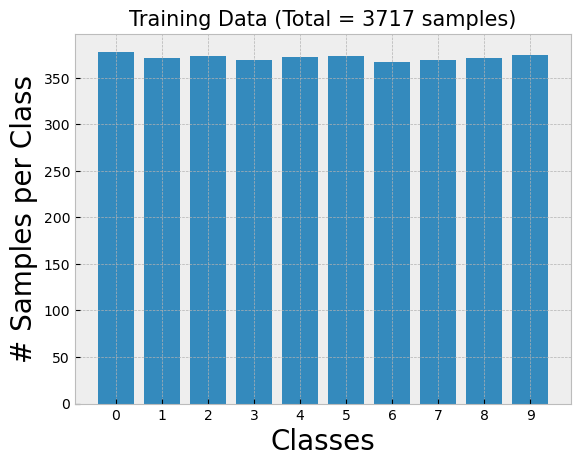

In [11]:
# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

In [15]:
# Labels Integer Encoding

labels_names = ['Nike',
                'Adidas',
                'Ford',
                'Honda',
                'General Mills',
                'Unilever',
                "McDonald's",
                'KFC',
                'Gators',
                '3M']

labels_names = ['Nike',
                'Adidas',
                'Ford',
                'Honda',
                'General_mills',
                'Unilever',
                "Mcdonalds",
                'KFC',
                'Gators',
                '3M']

In [16]:
for j in range (10):
    c = np.where(labels_train==j)[0]
    for i in range(len(c)):
        idx = c[i]
        img = data_train[:,idx].reshape((300,300,3))
        img = Image.fromarray(img, "RGB")
        image_filename = "c{}_{}.jpg".format(j,i)
        img.save("Try1/logo_photos/"+labels_names[j]+"/"+image_filename)


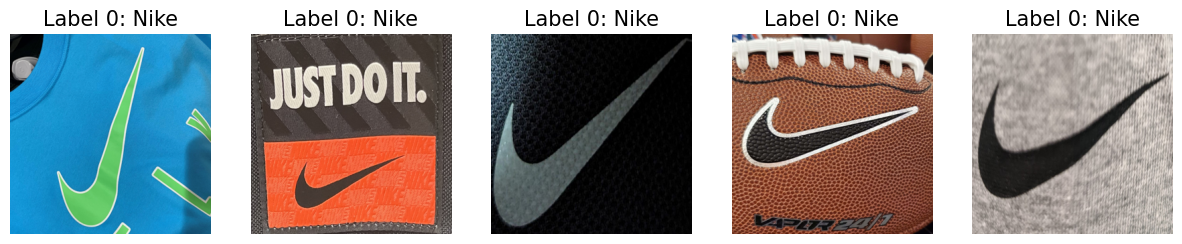

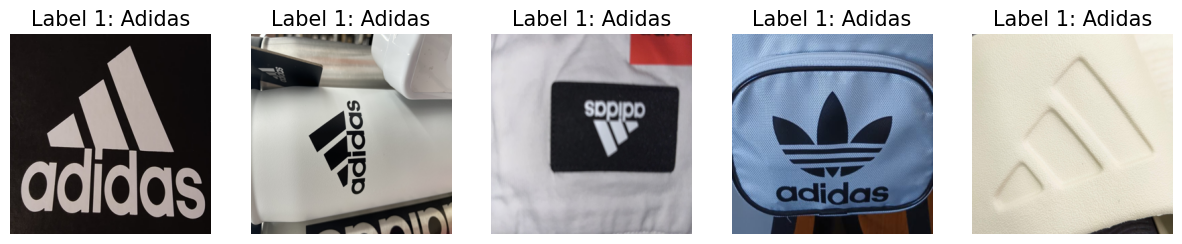

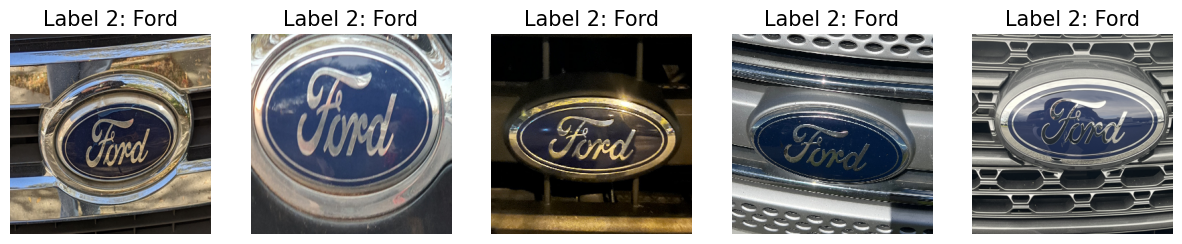

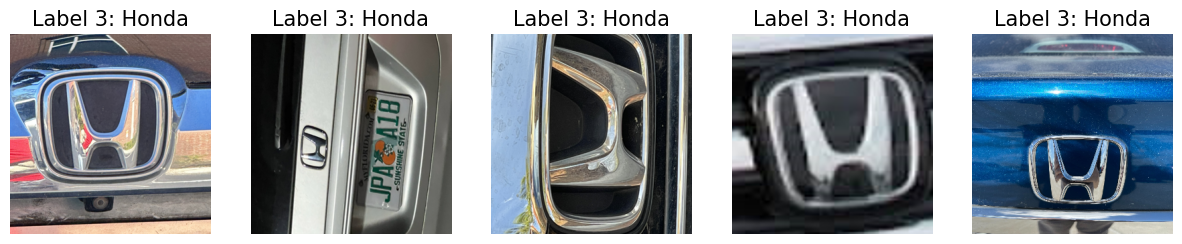

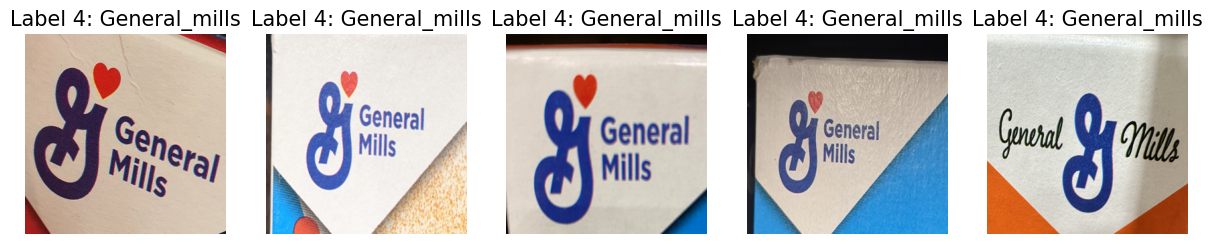

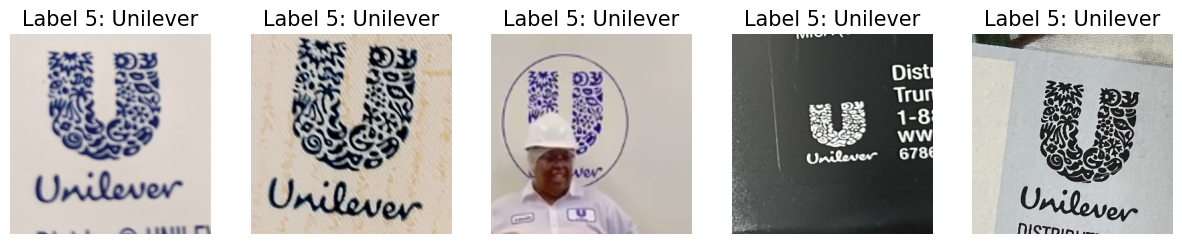

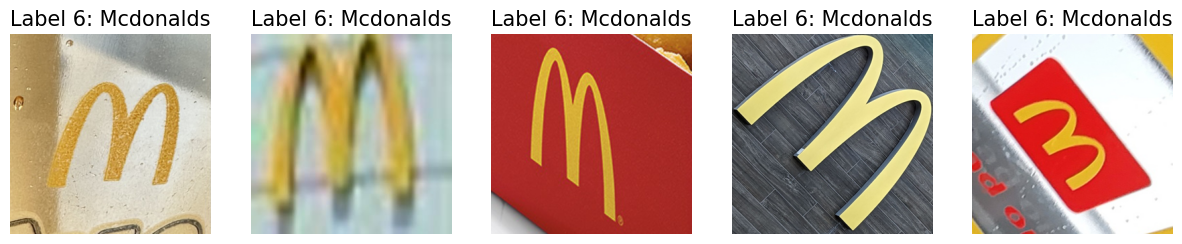

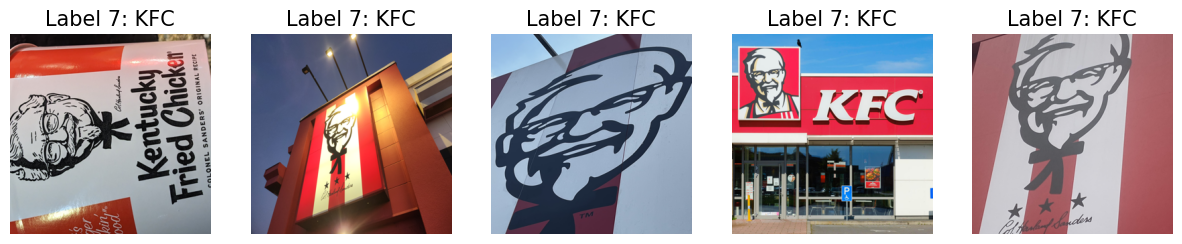

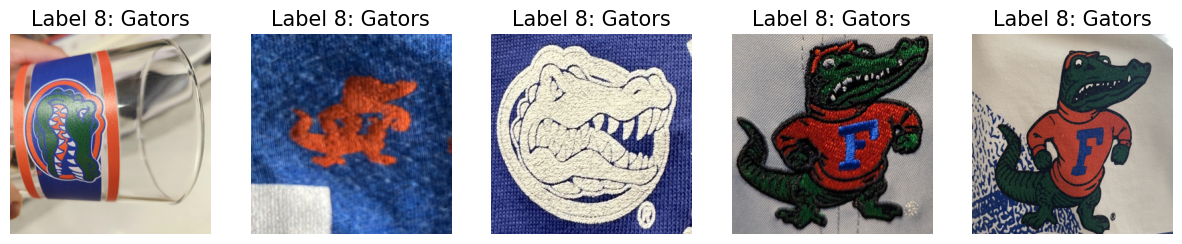

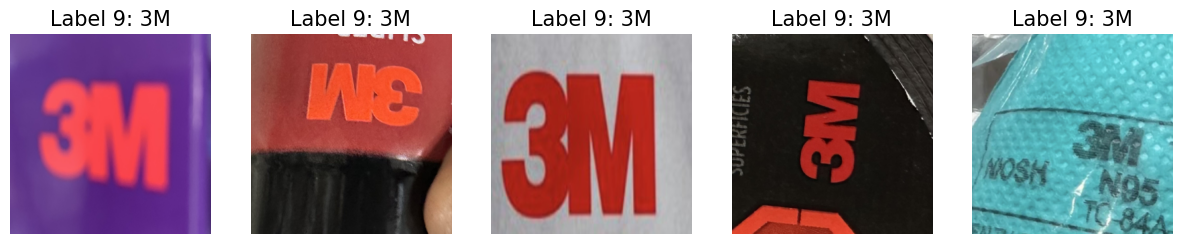

In [17]:
# # Displaying some examples per class

for i in range(0,10):
    rnd_sample = npr.permutation(np.where(labels_train==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(5):
        fig.add_subplot(1,5,j+1)
        plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300,3)))
        label_idx = int(labels_train[rnd_sample[j]])
        plt.axis('off');plt.title('Label '+str(label_idx)+': '+labels_names[label_idx],size=15)
    plt.show()
    print('\n\n')

In [28]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from skimage.transform import resize
from sklearn.svm import SVC
import cv2

In [45]:
image_resized = []
dim = (64, 64)
for i in range(len(data_train.T)):
    image = data_train[:,i].reshape((300,300,3))
    image_resized.append(cv2.resize(image, dim, interpolation = cv2.INTER_AREA))
    
image_resized = np.array(image_resized)

In [49]:
X_train, X_test, t_train, t_test = train_test_split(image_resized, labels_train, 
                                                   test_size=0.2,
                                                   stratify=labels_train,
                                                   random_state=1)
print(X_train.shape)
print(t_train.shape)
print(X_test.shape)
print(t_test.shape)

(2973, 64, 64, 3)
(2973,)
(744, 64, 64, 3)
(744,)


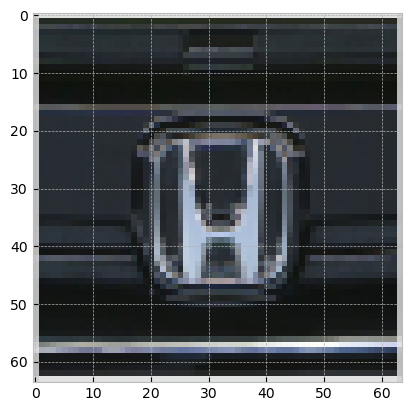

In [50]:
plt.imshow(X_train[11])



In [60]:
X_train = np.array([X_train[i].flatten() for i in range (len(X_train))])
X_test = np.array([X_test[i].flatten() for i in range (len(X_test))])

print(X_train.shape)
print(X_test.shape)

(2973, 12288)
(744, 12288)


### Model 1

In [ ]:
N, D = np.shape(X_train)
pca = PCA(n_components=min(N,D))
pca.fit(X_train)

plt.step(range(1,min(N,D)+1),np.cumsum(pca.explained_variance_ratio_)*100)

print(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9))
print(np.cumsum(pca.explained_variance_ratio_)[20])
plt.xlabel('Number of principal components');
plt.ylabel('% Variance explained');

In [ ]:
model1 = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=500)),
                 ('lr', LogisticRegression(random_state=0, tol=0.01))]) 

In [ ]:
model1.fit(X_train, t_train)

In [ ]:
Y_test = model1.predict(X_test)

print('With PCA:')
print('Test Accuracy Score = ',accuracy_score(t_test, Y_test))
print('Confusion matrix:')
print(confusion_matrix(t_test, Y_test))


### Model 2

In [96]:
model2 = Pipeline([('scaling', MinMaxScaler()),
                 ('pca', PCA(n_components=1000)),
                 ('svc_r' , SVC(kernel='rbf'))])

In [97]:
param2 = {
    'svc_r__C': np.logspace(-3, 3, 6),
    'svc_r__gamma': np.logspace(-3, 3, 6)
}

cval2 = GridSearchCV(model2, param_grid=param2, n_jobs=-1, cv=4, verbose=2)

cval2.fit(X_train, t_train)
print('SVM with RBF Hyperparameters:\n')
print(cval2.best_params_, '\n')

# model2.fit(X_train, t_train)



Fitting 4 folds for each of 36 candidates, totalling 144 fits
SVM with RBF Hyperparameters:

{'svc_r__C': 3.981071705534969, 'svc_r__gamma': 0.001} 



In [ ]:
Y_test2 = cval2.predict(X_test)

In [ ]:
print('SVM with RBF kernel\n')
print('Accuracy:\n',accuracy_score(t_test, Y_test2))
print ('F1_score:\n',f1_score(t_test, Y_test2, average=None))
print('Confusion matrix:\n',confusion_matrix(t_test, Y_test2))

SVM with RBF kernel

Accuracy:
 0.5309139784946236
F1_score:
 [0.31081081 0.45       0.41420118 0.48051948 0.69064748 0.52121212
 0.60810811 0.6031746  0.60606061 0.68027211]
Confusion matrix:
 [[23  7  9  7  0 10  8  4  5  2]
 [ 7 36  7  7  3  7  3  2  1  2]
 [ 6  5 35 15  1  8  0  1  3  0]
 [ 7  6 15 37  0  5  0  1  3  0]
 [ 4  9  3  3 48  5  2  1  0  0]
 [ 7  8  7  3  2 43  2  0  1  2]
 [ 6  3  2  3  3  2 45  0  3  6]
 [ 4  2  5  2  4  4  6 38  1  7]
 [ 5  7  8  3  0  4  4  1 40  3]
 [ 4  2  4  0  3  2  5  5  0 50]]
[CV] END .................svc_r__C=0.001, svc_r__gamma=0.001; total time=  27.7s
[CV] END .................svc_r__C=0.001, svc_r__gamma=0.001; total time=  54.7s
[CV] END ..svc_r__C=0.001, svc_r__gamma=0.015848931924611134; total time=  54.6s
[CV] END ..svc_r__C=0.001, svc_r__gamma=0.015848931924611134; total time=  54.5s
[CV] END ...svc_r__C=0.001, svc_r__gamma=0.25118864315095796; total time=  54.5s
[CV] END ...svc_r__C=0.001, svc_r__gamma=0.25118864315095796; total ti

### Model 3

In [66]:
model3 = Pipeline([('scaling', MinMaxScaler()),
                    ('LR' , LogisticRegression(tol = 0.01))])

In [67]:
model3.fit(X_train, t_train)

/apps/pytorch/1.13.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaling', MinMaxScaler()),
                ('LR', LogisticRegression(tol=0.01))])

---

In [68]:
Y_test3 = model3.predict(X_test)

In [69]:
print('LR\n')
print('Accuracy:\n',accuracy_score(t_test, Y_test3))
print ('F1_score:\n',f1_score(t_test, Y_test3, average=None))
print('Confusion matrix:\n',confusion_matrix(t_test, Y_test3))

LR

Accuracy:
 0.3655913978494624
F1_score:
 [0.15384615 0.27272727 0.28169014 0.27941176 0.46666667 0.33112583
 0.55782313 0.35135135 0.39285714 0.55033557]
Confusion matrix:
 [[11 10  7  3  8 11  4  7  7  7]
 [ 9 21  7 10  3  4  6  5  4  6]
 [ 7  7 20  9  5  6  1  3 14  2]
 [ 2  7 14 19  3  7  2  9 10  1]
 [ 3 10  3  3 35  8  3  6  4  0]
 [ 7  6  8  7  9 25  4  2  6  1]
 [ 3  2  2  3  1  3 41  7  6  5]
 [ 7  4  2  2  7  7  4 26  5  9]
 [ 9  9  3  5  2  1  6  5 33  2]
 [10  3  2  1  2  4  3  5  4 41]]


### Model4

In [91]:
model4 = Pipeline([('scaler', StandardScaler()),
                 ('lda', LDA(n_components=9)),
                 ('lr', LogisticRegression())])
model4.fit(X_train, t_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis(n_components=9)),
                ('lr', LogisticRegression())])

In [92]:
Y_test4 = model4.predict(X_test)

In [94]:
print('LR\n')
print('Accuracy:\n',accuracy_score(t_test, Y_test4))
print ('F1_score:\n',f1_score(t_test, Y_test4, average=None))
print('Confusion matrix:\n',confusion_matrix(t_test, Y_test4))

LR

Accuracy:
 0.1881720430107527
F1_score:
 [0.12403101 0.08196721 0.1322314  0.13333333 0.22222222 0.11827957
 0.34871795 0.08       0.10810811 0.34482759]
Confusion matrix:
 [[ 8  3  5 11  9 15  9  1  4 10]
 [ 7  5  4  7  7 14 12  4  3 12]
 [ 5  7  8 11 10 12  6  1  6  8]
 [ 4  7  6 10  7 13 11  3  6  7]
 [ 2  8  3  2 19 15  8  6  0 12]
 [ 5  8  6  7 11 11 10  0  5 12]
 [ 4  2  2  4  4  5 34  2  4 12]
 [ 6  2  4  5 11 15 13  4  0 13]
 [ 3  4  8 17 11  7  9  3  6  7]
 [10  1  1  2  7  4 10  3  2 35]]
